In [1]:
!pip install -q onnxruntime pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import onnxruntime
from pydub import AudioSegment
import torch
import numpy as np

audio_fname = 'testing_classroom_1.wav'

In [5]:
class OnnxWrapper():
    '''
    Code taken from: https://github.com/snakers4/silero-vad/blob/master/src/silero_vad/utils_vad.py

    See https://github.com/collabora/WhisperLive/blob/main/whisper_live/vad.py
    '''
    def __init__(self, path, force_onnx_cpu=False):
        opts = onnxruntime.SessionOptions()
        opts.inter_op_num_threads = 1
        opts.intra_op_num_threads = 1

        if force_onnx_cpu and 'CPUExecutionProvider' in onnxruntime.get_available_providers():
            self.session = onnxruntime.InferenceSession(path, providers=['CPUExecutionProvider'], sess_options=opts)
        else:
            self.session = onnxruntime.InferenceSession(path, sess_options=opts)

        self.reset_states()
        if '16k' in path:
            warnings.warn('This model support only 16000 sampling rate!')
            self.sample_rates = [16000]
        else:
            self.sample_rates = [8000, 16000]

    def _validate_input(self, x, sr: int):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        if x.dim() > 2:
            raise ValueError(f"Too many dimensions for input audio chunk {x.dim()}")

        if sr != 16000 and (sr % 16000 == 0):
            step = sr // 16000
            x = x[:,::step]
            sr = 16000

        if sr not in self.sample_rates:
            raise ValueError(f"Supported sampling rates: {self.sample_rates} (or multiply of 16000)")
        if sr / x.shape[1] > 31.25:
            raise ValueError("Input audio chunk is too short")

        return x, sr

    def reset_states(self, batch_size=1):
        self._state = torch.zeros((2, batch_size, 128)).float()
        self._context = torch.zeros(0)
        self._last_sr = 0
        self._last_batch_size = 0

    def __call__(self, x, sr: int):

        x, sr = self._validate_input(x, sr)
        num_samples = 512 if sr == 16000 else 256

        if x.shape[-1] != num_samples:
            raise ValueError(f"Provided number of samples is {x.shape[-1]} (Supported values: 256 for 8000 sample rate, 512 for 16000)")

        batch_size = x.shape[0]
        context_size = 64 if sr == 16000 else 32

        if not self._last_batch_size:
            self.reset_states(batch_size)
        if (self._last_sr) and (self._last_sr != sr):
            self.reset_states(batch_size)
        if (self._last_batch_size) and (self._last_batch_size != batch_size):
            self.reset_states(batch_size)

        if not len(self._context):
            self._context = torch.zeros(batch_size, context_size)

        x = torch.cat([self._context, x], dim=1)
        if sr in [8000, 16000]:
            ort_inputs = {'input': x.numpy(), 'state': self._state.numpy(), 'sr': np.array(sr, dtype='int64')}
            ort_outs = self.session.run(None, ort_inputs)
            out, state = ort_outs
            self._state = torch.from_numpy(state)
        else:
            raise ValueError()

        self._context = x[..., -context_size:]
        self._last_sr = sr
        self._last_batch_size = batch_size

        out = torch.from_numpy(out)
        return out

    def audio_forward(self, x, sr: int):
        outs = []
        x, sr = self._validate_input(x, sr)
        self.reset_states()
        num_samples = 512 if sr == 16000 else 256

        if x.shape[1] % num_samples:
            pad_num = num_samples - (x.shape[1] % num_samples)
            x = torch.nn.functional.pad(x, (0, pad_num), 'constant', value=0.0)

        for i in range(0, x.shape[1], num_samples):
            wavs_batch = x[:, i:i+num_samples]
            out_chunk = self.__call__(wavs_batch, sr)
            outs.append(out_chunk)

        stacked = torch.cat(outs, dim=1)
        return stacked.cpu()




class VoiceActivityDetector:
    '''
    See https://github.com/collabora/WhisperLive/blob/main/whisper_live/vad.py

    Onxx model:
    '''
    def __init__(self, path, threshold=0.5, frame_rate=16000):
        """
        Initializes the VoiceActivityDetector with a voice activity detection model and a threshold.

        Args:
            threshold (float, optional): The probability threshold for detecting voice activity. Defaults to 0.5.
        """
        self.model = OnnxWrapper(path=path,force_onnx_cpu=True)
        self.threshold = threshold
        self.frame_rate = frame_rate

    def __call__(self, audio_frame):
        """
        Determines if the given audio frame contains speech by comparing the detected speech probability against
        the threshold.

        Args:
            audio_frame (np.ndarray): The audio frame to be analyzed for voice activity. It is expected to be a
                                      NumPy array of audio samples.

        Returns:
            bool: True if the speech probability exceeds the threshold, indicating the presence of voice activity;
                  False otherwise.
        """
        speech_probs = self.model.audio_forward(torch.from_numpy(audio_frame.copy()), self.frame_rate)[0]
        return torch.any(speech_probs > self.threshold).item()

In [6]:
vad_model_path = './silero_vad.onnx'
vad_threshold = 0.5
vad_detector = VoiceActivityDetector(vad_model_path,vad_threshold,16000) # Load the Silero VAD model

## VAD configs

- Chunk size
- VAD threshold

In [7]:
def get_chunk_duration(chunk_size,sr):
  return chunk_size/sr

get_chunk_duration(4096*3,16000)

0.768

In [8]:
def get_chunk_size(chunk_duration,sr):
  return chunk_duration*sr
#get_chunk_size(1,16000)

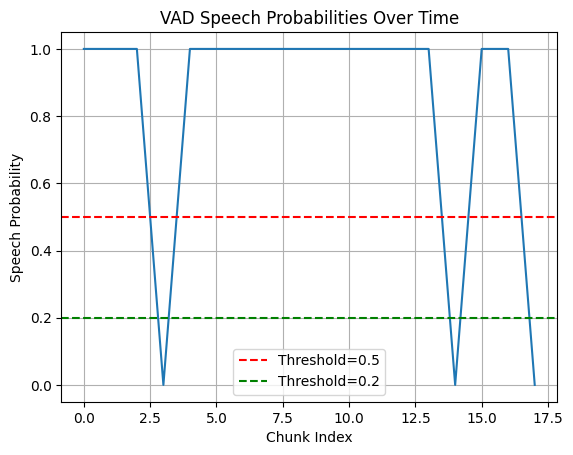

In [11]:
audio = AudioSegment.from_file(audio_fname)
audio = audio.set_frame_rate(16000).set_channels(1).set_sample_width(2)  # ensure 16kHz, mono, 16-bit PCM

audio = audio[6000:56000]

# Get the length of the audio file
audio_duration_seconds = audio.duration_seconds

# Convert to raw samples
audio_samples = np.array(audio.get_array_of_samples()).astype(np.float32) / 32768

# https://docs.rs/voice_activity_detector/latest/voice_activity_detector/#:~:text=This%20implementation%20uses%20the%20Silero,an%208000%20hz%20sample%20rate.
'''
It is trained using chunk sizes of 512, 768, 1024 samples for a 16,000 hz sample rate. These values are recommended for optimal performance, but are not required.
The only requirement imposed by the underlying model is the sample rate must be no larger than 31.25 times the chunk size.
'''
chunk = 4096*3

probs = []
for i in range(0, len(audio_samples), chunk):
    chunk_audio = audio_samples[i:i+chunk]
    if len(chunk_audio) < 512:
        chunk_audio = np.pad(chunk_audio, (0, 512 - len(chunk_audio)))
    prob = vad_detector(chunk_audio)  # assumes your model returns probability
    probs.append(prob)

plt.plot(probs)
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold=0.5')
plt.axhline(y=0.2, color='g', linestyle='--', label='Threshold=0.2')
plt.xlabel("Chunk Index")
plt.ylabel("Speech Probability")
plt.title("VAD Speech Probabilities Over Time")
plt.legend()
plt.grid()
plt.show()